[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/_HOWTOs/fractionation_factors.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/_HOWTOs/fractionation_factors.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/_HOWTOs/fractionation_factors.ipynb)

# Isotopic fractionation factors (kinetic and equilibrium) HOWTO
- $\alpha(T)$ is a fractionation factor for water isotopologues, factors are different wrt ice and liquid phase
- Kinetic fractionation is described in [Jouzel & Merlivat 1984](https://doi.org/10.1029/JD089iD07p11749), eq. (11). Then, effective fractionation factor is a product of equilibrium and kinetic ones
$$\alpha_\text{eff}(T) = \alpha_\text{eq}(T) \alpha_\text{kin}(T)$$

This _HOWTO_ presents calculations of effective fractionation factors $\alpha\text{eff}$ with respect to ice and liquid for deuterium ($^2$H). 

In [1]:
import os, sys
os.environ['NUMBA_THREADING_LAYER'] = 'workqueue'  # PySDM & PyMPDATA don't work with TBB; OpenMP has extra dependencies on macOS
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples', 'PySDM')

In [2]:
import numpy as np
from matplotlib import pyplot
from functools import partial
from open_atmos_jupyter_utils import show_plot

from PySDM import Formulae
from PySDM.physics import si

formulae, considered saturation range, temperature profile (here linear)

In [3]:
formulae = Formulae(
    isotope_equilibrium_fractionation_factors="MerlivatAndNief1967+Majoube1970+Majoube1971",
    isotope_kinetic_fractionation_factors="JouzelAndMerlivat1984",
    isotope_diffusivity_ratios="Stewart1975"
)

relative_humidity = np.linspace(.7, 1.1, 7)

temperature_C = np.linspace(-30, 0)
temperature = formulae.trivia.C2K(temperature_C) * si.K

fractionation factors for $^2$H in given temperature range (wrt ice and liquid, kinetic and equilibrium)

In [4]:
alpha_l = formulae.isotope_equilibrium_fractionation_factors.alpha_l_2H(temperature)
alpha_l_kinetic = partial(
    formulae.isotope_kinetic_fractionation_factors.alpha_kinetic,
    alpha_equilibrium=alpha_l,
    D_ratio_heavy_to_light=formulae.isotope_diffusivity_ratios.ratio_2H_heavy_to_light(temperature)
)

alpha_i = formulae.isotope_equilibrium_fractionation_factors.alpha_i_2H(temperature)
alpha_i_kinetic = partial(
    formulae.isotope_kinetic_fractionation_factors.alpha_kinetic,
    alpha_equilibrium=alpha_i,
    D_ratio_heavy_to_light=formulae.isotope_diffusivity_ratios.ratio_2H_heavy_to_light(temperature)
)

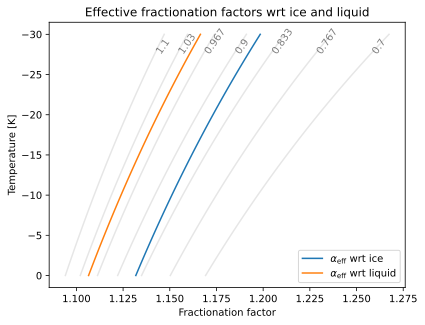

In [5]:
for rh in relative_humidity:
    alpha_eff = alpha_l * alpha_l_kinetic(relative_humidity=rh)
    pyplot.plot(alpha_eff, temperature_C, 'k', alpha=0.1)
    pyplot.annotate(f'{rh:.3g}', xy=(alpha_eff[4], temperature_C[4]), rotation=55, color='k', alpha=0.5, size=10)

pyplot.plot(alpha_i_kinetic(relative_humidity=1)*alpha_i, temperature_C, label=r'$\alpha_\text{eff}$ wrt ice')
pyplot.plot(alpha_l_kinetic(relative_humidity=1)*alpha_l, temperature_C, label=r'$\alpha_\text{eff}$ wrt liquid')
pyplot.gca().set(
    xlabel='Fractionation factor',
    ylabel="Temperature [K]",
)
pyplot.gca().invert_yaxis()
pyplot.title("Effective fractionation factors wrt ice and liquid")
pyplot.legend()
show_plot()
